In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

from tqdm import trange


# fix random seed for reproducibility
numpy.random.seed(7)

2022-12-04 19:38:20.049368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 19:38:22.429351: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-04 19:38:22.429655: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-04 19:38:22.429675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [3]:
def load_dataset(datasource: str) -> (numpy.ndarray, MinMaxScaler):
    """
    The function loads dataset from given file name and uses MinMaxScaler to transform data
    :param datasource: file name of data source
    :return: tuple of dataset and the used MinMaxScaler
    """
    # load the dataset
    dataframe = pandas.read_csv(datasource, usecols=[1])
    dataframe = dataframe.fillna(method='pad')
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    plt.plot(dataset)
    plt.show()

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler


In [4]:
def create_dataset(dataset: numpy.ndarray, look_back: int = 1) -> (numpy.ndarray, numpy.ndarray):
    """
    The function takes two arguments: the `dataset`, which is a NumPy array that we want to convert into a dataset,
    and the `look_back`, which is the number of previous time steps to use as input variables
    to predict the next time period — in this case defaulted to 1.
    :param dataset: numpy dataset
    :param look_back: number of previous time steps as int
    :return: tuple of input and output dataset
    """
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        data_x.append(a)
        data_y.append(dataset[i + look_back, 0])
    return numpy.array(data_x), numpy.array(data_y)

In [5]:
def split_dataset(dataset: numpy.ndarray, train_size, look_back) -> (numpy.ndarray, numpy.ndarray):
    """
    Splits dataset into training and test datasets. The last `look_back` rows in train dataset
    will be used as `look_back` for the test dataset.
    :param dataset: source dataset
    :param train_size: specifies the train data size
    :param look_back: number of previous time steps as int
    :return: tuple of training data and test dataset
    """
    if not train_size > look_back:
        raise ValueError('train_size must be lager than look_back')
    train, test = dataset[0:train_size,
                          :], dataset[train_size - look_back:len(dataset), :]
    print('train_dataset: {}, test_dataset: {}'.format(len(train), len(test)))
    return train, test

In [6]:
def build_model(look_back: int, batch_size: int = 1) -> Sequential:
    """
    The function builds a keras Sequential model
    :param look_back: number of previous time steps as int
    :param batch_size: batch_size as int, defaults to 1
    :return: keras Sequential model
    """
    model = Sequential()
    model.add(LSTM(64,
                   activation='relu',
                   batch_input_shape=(batch_size, look_back, 1),
                   stateful=True,
                   return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [7]:
def plot_data(dataset: numpy.ndarray,
              look_back: int,
              train_predict: numpy.ndarray,
              test_predict: numpy.ndarray,
              forecast_predict: numpy.ndarray):
    """
    Plots baseline and predictions.

    blue: baseline
    green: prediction with training data
    red: prediction with test data
    cyan: prediction based on predictions

    :param dataset: dataset used for predictions
    :param look_back: number of previous time steps as int
    :param train_predict: predicted values based on training data
    :param test_predict: predicted values based on test data
    :param forecast_predict: predicted values based on previous predictions
    :return: None
    """
    plt.plot(dataset)
    plt.plot([None for _ in range(look_back)] +
             [x for x in train_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [x for x in test_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [None for _ in test_predict] +
             [x for x in forecast_predict])
    plt.show()


In [8]:
def make_forecast(model: Sequential, look_back_buffer: numpy.ndarray, timesteps: int = 1, batch_size: int = 1):
    forecast_predict = numpy.empty((0, 1), dtype=numpy.float32)
    for _ in trange(timesteps, desc='predicting data\t', mininterval=1.0):
        # make prediction with current lookback buffer
        cur_predict = model.predict(look_back_buffer, batch_size)
        # add prediction to result
        forecast_predict = numpy.concatenate(
            [forecast_predict, cur_predict], axis=0)
        # add new axis to prediction to make it suitable as input
        cur_predict = numpy.reshape(
            cur_predict, (cur_predict.shape[1], cur_predict.shape[0], 1))
        # remove oldest prediction from buffer
        look_back_buffer = numpy.delete(look_back_buffer, 0, axis=1)
        # concat buffer with newest prediction
        look_back_buffer = numpy.concatenate(
            [look_back_buffer, cur_predict], axis=1)
    return forecast_predict

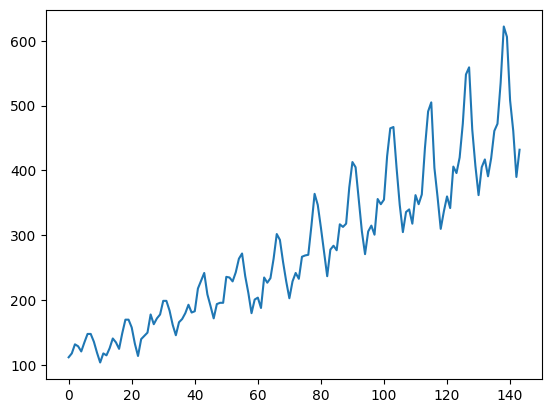

In [9]:
datasource = 'international-airline-passengers.csv'
dataset, scaler = load_dataset(datasource)

In [10]:
# split into train and test sets
look_back = int(len(dataset) * 0.20)
train_size = int(len(dataset) * 0.70)
train, test = split_dataset(dataset, train_size, look_back)


train_dataset: 100, test_dataset: 72


In [11]:
# reshape into X=t and Y=t+1
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)


In [12]:
# reshape input to be [samples, time steps, features]
train_x = numpy.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = numpy.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))


In [13]:
# create and fit Multilayer Perceptron model
batch_size = 1
model = build_model(look_back, batch_size=batch_size)
for _ in trange(100, desc='fitting model\t', mininterval=1.0):
    model.fit(train_x, train_y, epochs=1,
                batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()


2022-12-04 19:39:00.054581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 19:39:00.062103: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 19:39:00.062156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-f093ae): /proc/driver/nvidia/version does not exist
2022-12-04 19:39:00.062953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
fitting model	: 100%|██████████| 100/100 [00:40<00:00,  2.

In [14]:
# generate predictions for training
train_predict = model.predict(train_x, batch_size)
test_predict = model.predict(test_x, batch_size)


43/43 [==============================] - 0s 2ms/step


In [15]:
# generate forecast predictions
forecast_predict = make_forecast(
    model, test_x[-1::], timesteps=100, batch_size=batch_size)


predicting data	:   0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


predicting data	:  23%|██▎       | 23/100 [00:01<00:03, 22.05it/s]

1/1 [==============================] - 0s 17ms/step


predicting data	:  46%|████▌     | 46/100 [00:02<00:02, 21.95it/s]

1/1 [==============================] - 0s 15ms/step


predicting data	:  69%|██████▉   | 69/100 [00:03<00:01, 22.27it/s]

1/1 [==============================] - 0s 18ms/step


predicting data	:  92%|█████████▏| 92/100 [00:04<00:00, 22.06it/s]

1/1 [==============================] - 0s 16ms/step


predicting data	: 100%|██████████| 100/100 [00:04<00:00, 22.19it/s]


In [16]:
# invert dataset and predictions
dataset = scaler.inverse_transform(dataset)
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])
forecast_predict = scaler.inverse_transform(forecast_predict)


In [17]:
# calculate root mean squared error
train_score = numpy.sqrt(mean_squared_error(
    train_y[0], train_predict[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = numpy.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print('Test Score: %.2f RMSE' % test_score)


Train Score: 15.82 RMSE
Test Score: 56.35 RMSE


/home/codespace/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


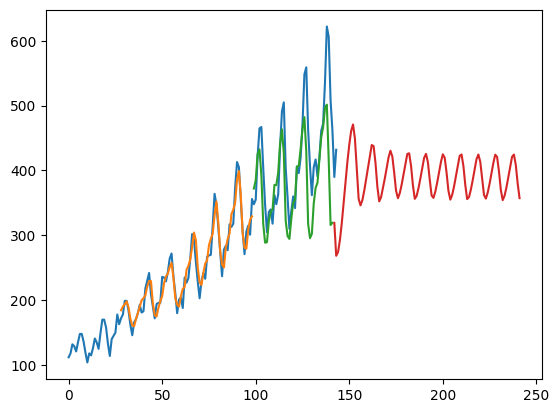

In [18]:
plot_data(dataset, look_back, train_predict,
            test_predict, forecast_predict)
